In [74]:
import os, sys
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch_geometric.loader import DataLoader as GeoDataLoader
from main.dataset import BrainTumorDataset
from models.cnn import SimpleCNN
from models.gnn import GNNClassifier
from main.train_gnn import extract_cnn_features, build_graph

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


ImportError: cannot import name 'extract_cnn_features' from 'main.train_gnn' (c:\Users\KRISTINE\projects\brain-tumour-multimodal-analysis\main\train_gnn.py)

In [75]:
DATA_ROOT = "../data"
NUM_CLASSES = 4
BATCH_SIZE = 16
CNN_MODEL_PATH = "cnn_brain_tumor_classifier.pth"
TEST_DIR = os.path.join(DATA_ROOT, "Testing")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_dataset = BrainTumorDataset(root_dir=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

cnn_model = SimpleCNN(num_classes=NUM_CLASSES).to(device)
cnn_model.load_state_dict(torch.load(CNN_MODEL_PATH, map_location=device))
cnn_model.eval()


Class to index mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [ ]:
test_features, test_labels = extract_cnn_features(cnn_model, test_loader, device)
graph_data = build_graph(test_features, test_labels, k=5).to(device)
graph_loader = GeoDataLoader([graph_data], batch_size=1)
print(f"Test graph: {graph_data.num_nodes} nodes, {graph_data.num_edges} edges")


c:\Users\KRISTINE\projects\brain-tumour-multimodal-analysis\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KRISTINE\projects\brain-tumour-multimodal-analysis\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting ResNet features: 100%|██████████| 25/25 [00:10<00:00,  2.38it/s]

Extracted features shape: (394, 512)


In [ ]:
gnn_model = GNNClassifier(
    in_channels=test_features.shape[1],
    hidden_channels=256,
    out_channels=NUM_CLASSES
).to(device)

GNN_MODEL_PATH = "gnn_brain_tumor_classifier.pth"
gnn_model.load_state_dict(torch.load(GNN_MODEL_PATH, map_location=device))
gnn_model.eval()
print("GNN model loaded successfully.")


c:\Users\KRISTINE\projects\brain-tumour-multimodal-analysis\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
y_true, y_pred = [], []

with torch.no_grad():
    for batch in graph_loader:
        out = gnn_model(batch.x, batch.edge_index)
        preds = out.argmax(dim=1)
        y_true.extend(batch.y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=test_dataset.idx_to_class.values()))


Test graph has 394 nodes and 788 edges


In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.idx_to_class.values(), yticklabels=test_dataset.idx_to_class.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("GNN Confusion Matrix")
plt.show()


RuntimeError: Error(s) in loading state_dict for GNNClassifier:
	size mismatch for conv1.lin.weight: copying a param with shape torch.Size([256, 128]) from checkpoint, the shape in current model is torch.Size([256, 512]).

In [ ]:
sample_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
sample_batch = next(iter(sample_loader))
images, labels = sample_batch['image'].to(device), sample_batch['label'].to(device)

# Use CNN + GNN for predictions
with torch.no_grad():
    x = F.relu(cnn_model.conv1(images))
    x = cnn_model.pool1(x)
    x = F.relu(cnn_model.conv2(x))
    x = cnn_model.pool2(x)
    x = F.relu(cnn_model.conv3(x))
    x = cnn_model.pool3(x)
    x = nn.AdaptiveAvgPool2d((1,1))(x).view(x.size(0), -1)
    out = gnn_model(x, build_graph(x.cpu().numpy(), labels.cpu().numpy(), k=5).edge_index.to(device))
    preds = out.argmax(dim=1)

plt.figure(figsize=(12,8))
for i in range(8):
    ax = plt.subplot(2,4,i+1)
    img = images[i].cpu().numpy().transpose(1,2,0)
    img = np.clip(img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0, 1)
    plt.imshow(img)
    plt.title(f"Pred: {test_dataset.idx_to_class[preds[i].item()]}\nTrue: {test_dataset.idx_to_class[labels[i].item()]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


Predictions done!


In [58]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")


Accuracy: 0.4289
Precision : 0.4726
Recall : 0.4289


c:\Users\KRISTINE\projects\brain-tumour-multimodal-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [59]:
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))


--- Classification Report ---
                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00       100
meningioma_tumor       0.34      0.97      0.50       115
        no_tumor       0.69      0.24      0.35       105
 pituitary_tumor       1.00      0.45      0.62        74

        accuracy                           0.43       394
       macro avg       0.51      0.41      0.37       394
    weighted avg       0.47      0.43      0.36       394



c:\Users\KRISTINE\projects\brain-tumour-multimodal-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KRISTINE\projects\brain-tumour-multimodal-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\KRISTINE\projects\brain-tumour-multimodal-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

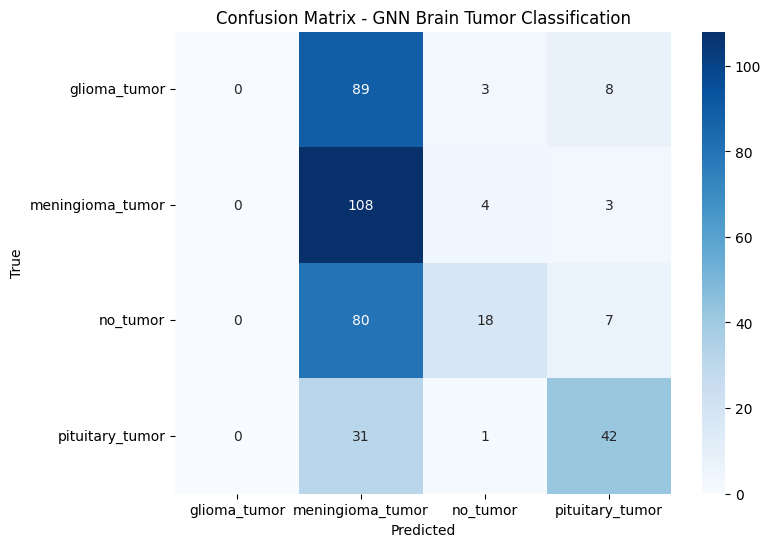

In [48]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GNN Brain Tumor Classification')
plt.show()

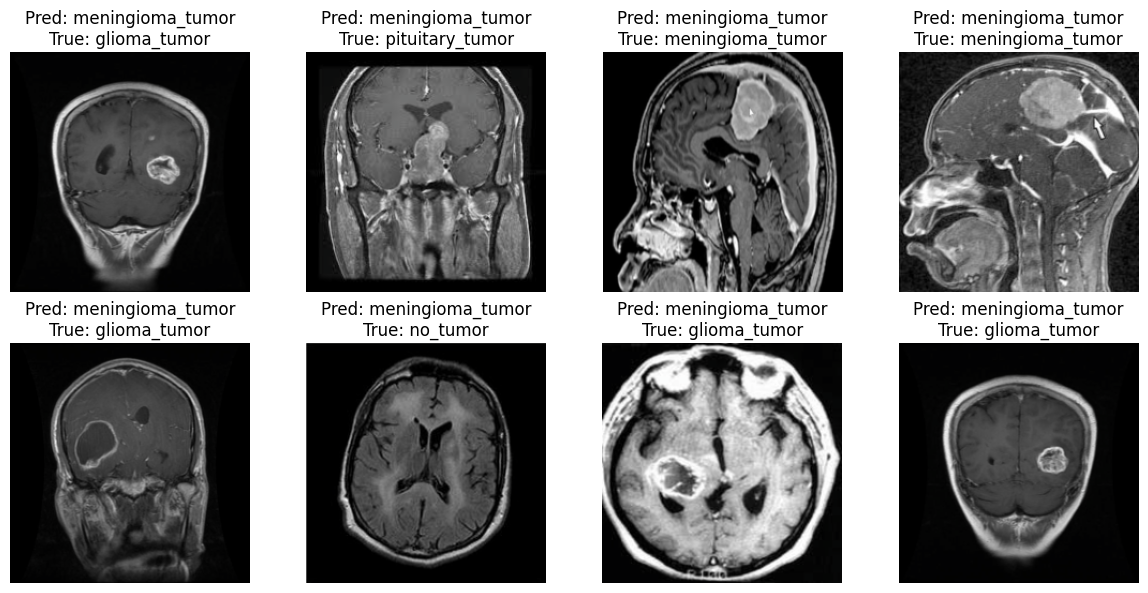

In [49]:
sample_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
sample_batch = next(iter(sample_loader))
images, labels = sample_batch['image'].to(DEVICE), sample_batch['label']

with torch.no_grad():
    features_batch = resnet(images)
    # Build mini-graph for batch (simplified: fully connected within batch)
    num_nodes = features_batch.shape[0]
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1).to(DEVICE)
    preds_batch = torch.argmax(gnn_model(features_batch, edge_index), dim=1).cpu().numpy()

images = images.cpu().numpy()
labels = labels.numpy()

plt.figure(figsize=(12, 6))
for i in range(len(images)):
    ax = plt.subplot(2, 4, i+1)
    img = images[i].transpose((1,2,0))
    img = np.clip(img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0,1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[preds_batch[i]]}\nTrue: {class_names[labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()